In [1]:
!pip install pydot
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


In [3]:
BASE_DIR = './UTKFace_1000_subset'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,./UTKFace_1000_subset\10_1_0_20170109203917216...,10,1
1,./UTKFace_1000_subset\10_1_0_20170109204746535...,10,1
2,./UTKFace_1000_subset\10_1_2_20170103201007646...,10,1
3,./UTKFace_1000_subset\10_1_3_20170104221711437...,10,1
4,./UTKFace_1000_subset\11_0_0_20170110224606036...,11,0


In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

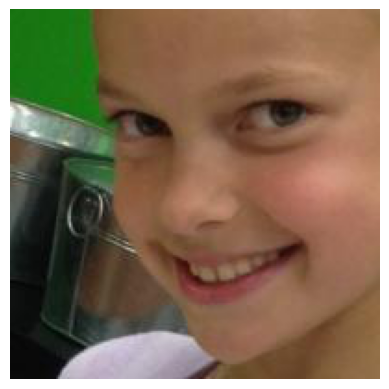

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

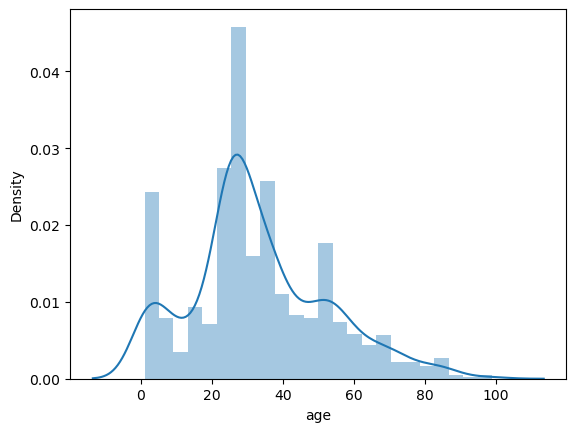

In [8]:
sns.distplot(df['age'])

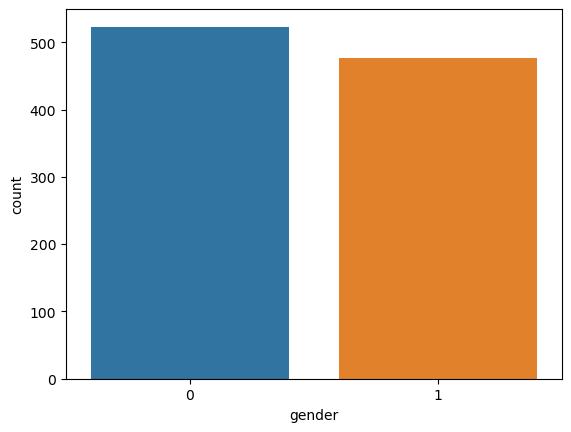

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='gender', data=df)
plt.show()


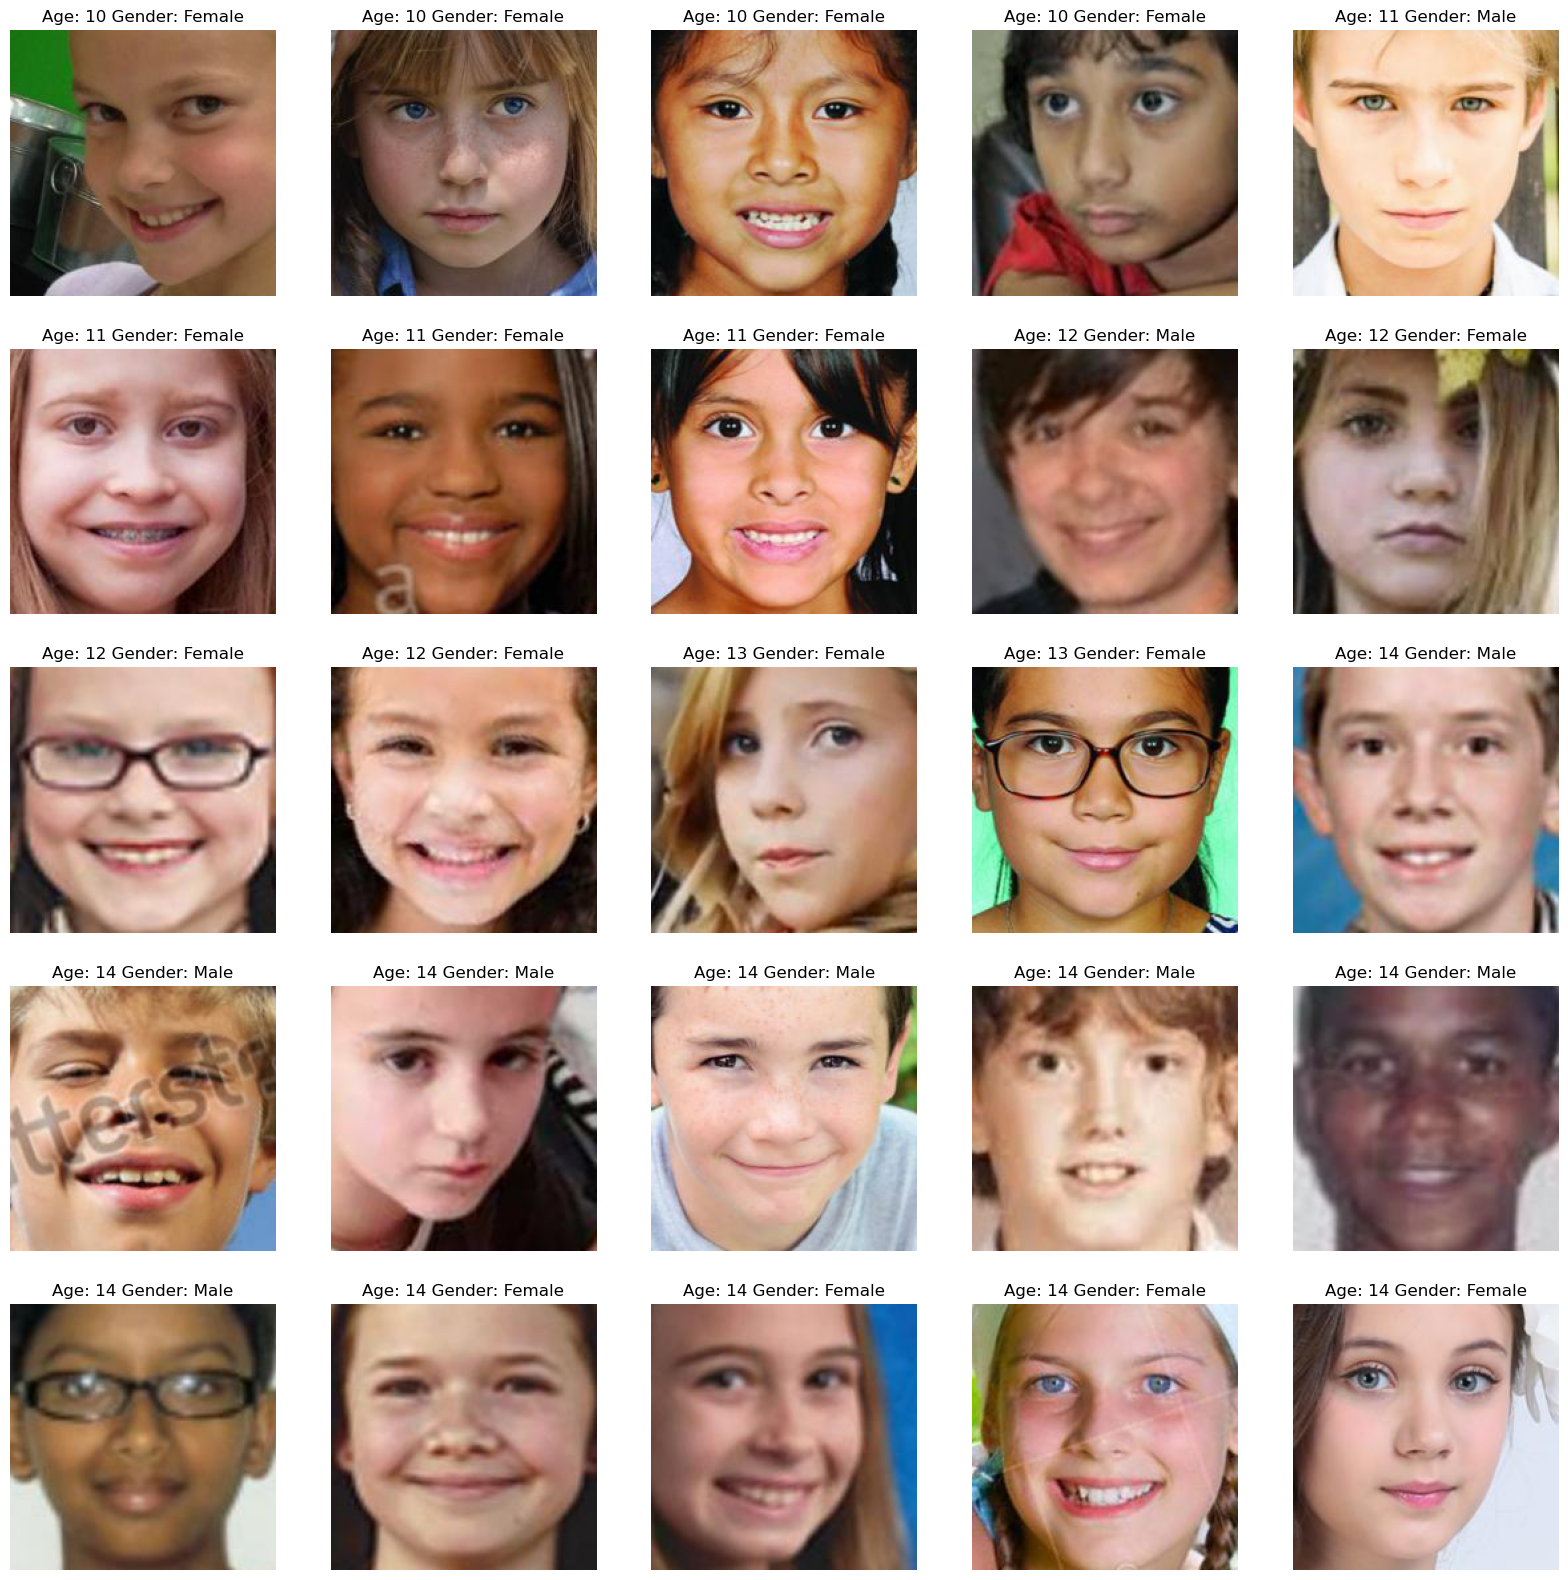

In [10]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[int(gender)]}")
    plt.axis('off')


In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
X.shape

(1000, 128, 128, 1)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

In [17]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(
    optimizer='adam',
    loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)


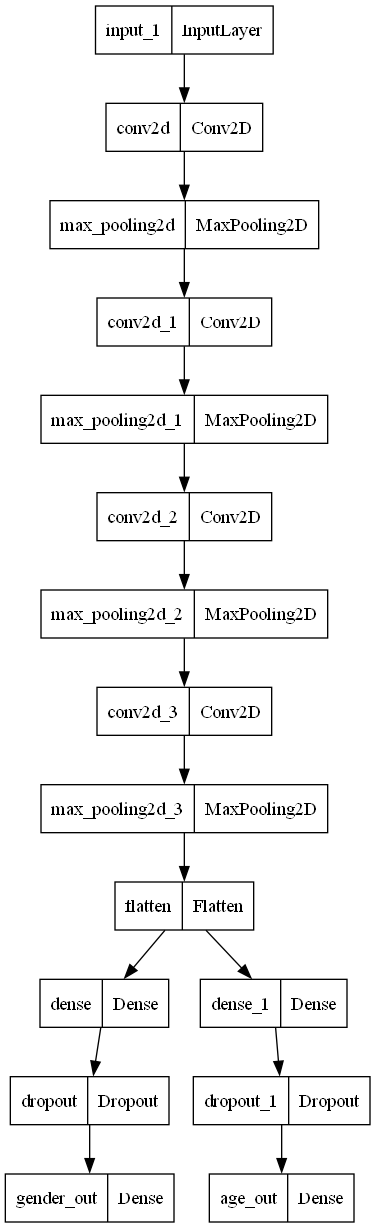

In [18]:
 #plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
# train model
history = model.fit(
    x=X,
    y={'gender_out': y_gender, 'age_out': y_age},
    batch_size=32,
    epochs=30,
    validation_split=0.2
)

Epoch 1/30


25/25 [==============================] - 11s 348ms/step - loss: 19.3586 - gender_out_loss: 0.9718 - age_out_loss: 18.3868 - gender_out_accuracy: 0.4950 - age_out_mae: 18.3868 - val_loss: 38.5350 - val_gender_out_loss: 0.7170 - val_age_out_loss: 37.8180 - val_gender_out_accuracy: 0.4000 - val_age_out_mae: 37.8180
Epoch 2/30
25/25 [==============================] - 8s 301ms/step - loss: 12.5786 - gender_out_loss: 0.7055 - age_out_loss: 11.8731 - gender_out_accuracy: 0.5400 - age_out_mae: 11.8731 - val_loss: 37.6728 - val_gender_out_loss: 0.6781 - val_age_out_loss: 36.9947 - val_gender_out_accuracy: 0.6150 - val_age_out_mae: 36.9947
Epoch 3/30
25/25 [==============================] - 7s 300ms/step - loss: 12.2521 - gender_out_loss: 0.6969 - age_out_loss: 11.5552 - gender_out_accuracy: 0.5325 - age_out_mae: 11.5552 - val_loss: 36.2843 - val_gender_out_loss: 0.6459 - val_age_out_loss: 35.6384 - val_gender_out_accuracy: 0.6400 - val_age_out_mae: 35.6384
Epoch 4/30
25/25 [=======

In [21]:
model.save("model.h5")
print("Model saved as model.h5")



Model saved as model.h5


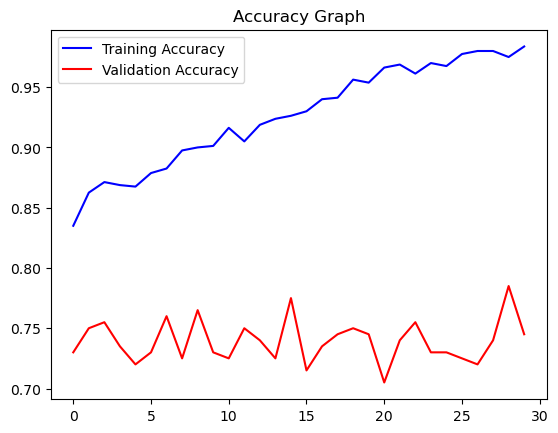

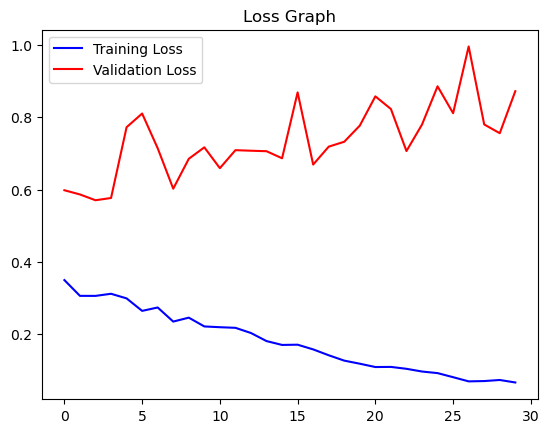

In [52]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

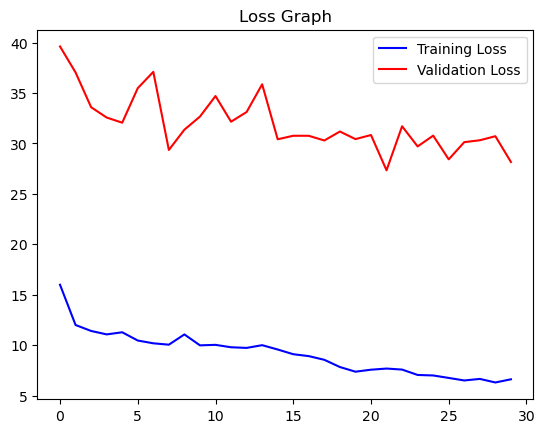

In [22]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Prediction with Test Data

Original Gender: Female Original Age: 1
1/1 [==============================] - 0s 44ms/step
Predicted Gender: Female Predicted Age: 0


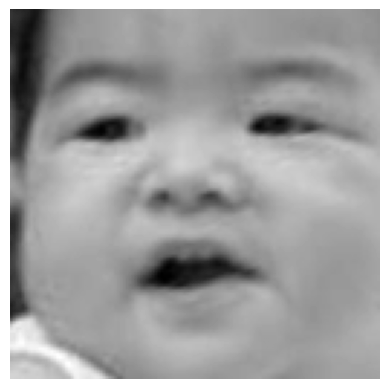

In [53]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 26
1/1 [==============================] - 0s 30ms/step
Predicted Gender: Female Predicted Age: 28


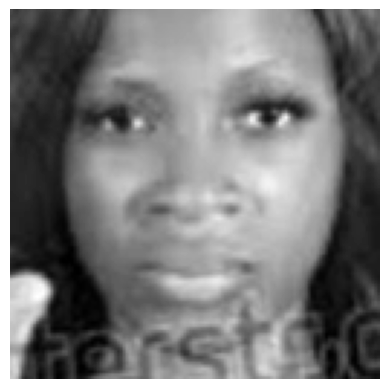

In [54]:
image_index = 300
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 32
1/1 [==============================] - 0s 31ms/step
Predicted Gender: Female Predicted Age: 35


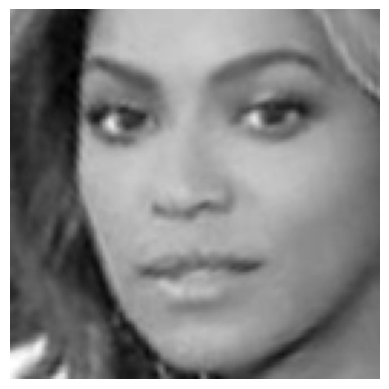

In [55]:
image_index = 500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 40
1/1 [==============================] - 0s 47ms/step
Predicted Gender: Male Predicted Age: 34


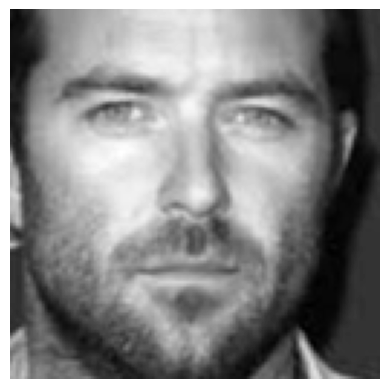

In [56]:
image_index = 650
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 65
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Female Predicted Age: 35


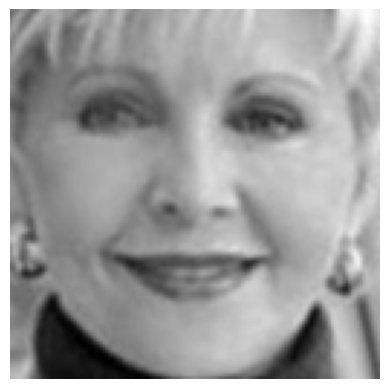

In [57]:
image_index = 900
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Female Predicted Age: 31


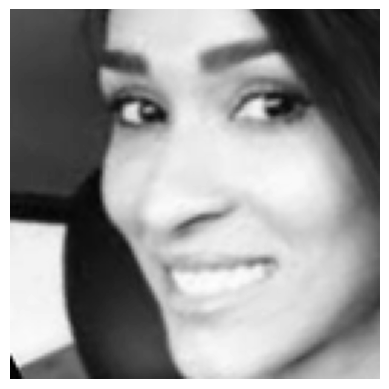

In [58]:
image_index = 420
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [6]:
torch.save(model.state_dict(), "model.pth")


NameError: name 'model' is not defined